# Semi-Supervised Learning — Revenue Tier Classification

**Goal:** Compare a supervised baseline against three semi-supervised methodologies and select the best-performing model for revenue tier prediction, evaluated on macro F1 on a held-out labeled test set.

**Dataset:** `data_ssl_revenue.csv` produced by the Feature Engineering pipeline.

**Target:** `y_ssl`
- 0 = Low, 1 = Medium, 2 = High, 3 = Blockbuster (labeled)
- -1 = unlabeled

**Models:**
1. GradientBoosting (supervised baseline)
2. RandomForest (supervised baseline)
3. SelfTraining (semi-supervised)
4. LabelSpreading (semi-supervised, graph-based)
5. LabelPropagation (semi-supervised, graph-based)

**Theoretical guarantees:**
- Train/test split on labeled data only
- Test set never participates in pseudo-labeling
- Unlabeled data used only during SSL fitting
- No post-release variables as features
- Scaler fitted only on labeled train
- PCA (if used) fitted only on training data
- All models evaluated on the same labeled test set
- Primary metric: macro F1

In [1]:
# ============================================================
# Imports
# ============================================================
import pandas as pd
import numpy as np
import warnings
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.semi_supervised import (
    SelfTrainingClassifier,
    LabelSpreading,
    LabelPropagation,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

warnings.filterwarnings("ignore")
print("All imports successful.")

All imports successful.


## 0. Load Dataset

In [2]:
# ============================================================
# Load the SSL revenue dataset
# ============================================================
DATA_DIR = "../data"
ARTIFACTS_DIR = "../data"  # save artifacts alongside datasets

df = pd.read_csv(os.path.join(DATA_DIR, "data_ssl_revenue.csv"))
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\ny_ssl value counts:\n{df['y_ssl'].value_counts().sort_index()}")

Dataset shape: (9290, 53)
Columns: ['runtime', 'director_popularity', 'actor1_popularity', 'actor2_popularity', 'actor3_popularity', 'actor4_popularity', 'actor5_popularity', 'cast_pop_mean', 'cast_pop_max', 'release_month', 'release_year', 'release_quarter', 'is_summer_release', 'is_holiday_release', 'star_count', 'cast_popularity_std', 'cast_gender_ratio', 'director_is_female', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science Fiction', 'genre_TV Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'num_genres', 'keyword_count', 'lang_en', 'lang_fr', 'lang_es', 'lang_ja', 'lang_de', 'lang_other', 'is_english', 'revenue_missing_flag', 'budget_missing_flag', 'has_budget', 'log_budget', 'has_overview', 'overview_length', 'y_ssl']

y_ssl value counts:
y_ssl
-1    6686
 0     651
 1     6

---
## Validation 1 — Leakage Prevention

Remove any column whose name contains post-release or target keywords (`vote`, `review`, `rating`, `popularity`, `revenue`, `budget`). Keep `y_ssl` only as the target.

In [3]:
# ============================================================
# Validation 1 — Leakage prevention
# ============================================================
leakage_keywords = ["vote", "review", "rating", "popularity", "revenue", "budget"]

# All columns except y_ssl are candidate features
candidate_features = [c for c in df.columns if c != "y_ssl"]

# Remove any column whose name contains a leakage keyword
leaked_cols = [c for c in candidate_features
               if any(kw in c.lower() for kw in leakage_keywords)]

feature_cols = [c for c in candidate_features if c not in leaked_cols]

print(f"Candidate features before filter: {len(candidate_features)}")
print(f"Leaked columns removed ({len(leaked_cols)}): {leaked_cols}")
print(f"\nFinal feature count: {len(feature_cols)}")
print(f"First 20 features: {feature_cols[:20]}")

Candidate features before filter: 52
Leaked columns removed (11): ['director_popularity', 'actor1_popularity', 'actor2_popularity', 'actor3_popularity', 'actor4_popularity', 'actor5_popularity', 'cast_popularity_std', 'revenue_missing_flag', 'budget_missing_flag', 'has_budget', 'log_budget']

Final feature count: 41
First 20 features: ['runtime', 'cast_pop_mean', 'cast_pop_max', 'release_month', 'release_year', 'release_quarter', 'is_summer_release', 'is_holiday_release', 'star_count', 'cast_gender_ratio', 'director_is_female', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy']


## Validation 2 — Class Distribution

In [4]:
# ============================================================
# Validation 2 — Class distribution (labeled data)
# ============================================================
labeled_mask = df["y_ssl"] != -1
df_labeled = df[labeled_mask].copy()

class_counts = df_labeled["y_ssl"].value_counts().sort_index()
print(f"Class distribution (labeled rows):")
tier_names = {0: "Low", 1: "Medium", 2: "High", 3: "Blockbuster"}
for cls, cnt in class_counts.items():
    print(f"  {cls} ({tier_names.get(cls, '?')}): {cnt}")

n_classes = df_labeled["y_ssl"].nunique()
print(f"\nNumber of classes: {n_classes}")
assert n_classes == 4, f"Expected 4 classes, got {n_classes}"
print(f"Total labeled rows: {len(df_labeled)}")

Class distribution (labeled rows):
  0 (Low): 651
  1 (Medium): 651
  2 (High): 651
  3 (Blockbuster): 651

Number of classes: 4
Total labeled rows: 2604


## Validation 3 — Unlabeled Proportion

In [5]:
# ============================================================
# Validation 3 — Unlabeled proportion
# ============================================================
unlabeled_mask = df["y_ssl"] == -1
n_unlabeled = unlabeled_mask.sum()
pct_unlabeled = n_unlabeled / len(df) * 100

print(f"Unlabeled rows:  {n_unlabeled}")
print(f"Percentage:      {pct_unlabeled:.2f}%")
print(f"Labeled rows:    {(~unlabeled_mask).sum()}")
print(f"Total rows:      {len(df)}")

Unlabeled rows:  6686
Percentage:      71.97%
Labeled rows:    2604
Total rows:      9290


## Validation 4 — Feature Dimensionality

In [6]:
# ============================================================
# Validation 4 — Feature dimensionality
# ============================================================
n_features = len(feature_cols)
USE_PCA = n_features > 100

print(f"Total feature columns: {n_features}")
if USE_PCA:
    print(">> Feature count > 100 — will apply PCA (95% variance) for graph-based SSL methods.")
else:
    print(">> Feature count <= 100 — no PCA needed for graph-based methods.")

Total feature columns: 41
>> Feature count <= 100 — no PCA needed for graph-based methods.


## Validation 5 — Missing Features

In [7]:
# ============================================================
# Validation 5 — Missing features
# ============================================================
X_all = df[feature_cols].copy()
y_all = df["y_ssl"].copy()

missing_before = X_all.isnull().sum()
total_missing_before = missing_before.sum()
print(f"Total missing values BEFORE imputation: {total_missing_before}")

if total_missing_before > 0:
    print(f"\nMissing per column (non-zero):")
    print(missing_before[missing_before > 0])
    
    # Apply median imputation for numeric columns
    imputer = SimpleImputer(strategy="median")
    X_all_imputed = pd.DataFrame(
        imputer.fit_transform(X_all),
        columns=feature_cols,
        index=X_all.index
    )
    total_missing_after = X_all_imputed.isnull().sum().sum()
    print(f"\nTotal missing values AFTER imputation: {total_missing_after}")
    X_all = X_all_imputed
else:
    print("No missing values — no imputation needed.")

print(f"\nFinal feature matrix shape: {X_all.shape}")

Total missing values BEFORE imputation: 0
No missing values — no imputation needed.

Final feature matrix shape: (9290, 41)


---
# Experiment

## Step 1 — Split Labeled Data

In [8]:
# ============================================================
# Step 1 — Split labeled data only
# ============================================================

# Separate labeled and unlabeled feature matrices
X_labeled = X_all[labeled_mask].copy()
y_labeled = y_all[labeled_mask].copy()
X_unlabeled = X_all[unlabeled_mask].copy()

print(f"Labeled:   X={X_labeled.shape}  y={y_labeled.shape}")
print(f"Unlabeled: X={X_unlabeled.shape}")

# Stratified train/test split on labeled data
X_train_labeled, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled,
    test_size=0.2,
    random_state=42,
    stratify=y_labeled
)

print(f"\nAfter split:")
print(f"  X_train_labeled: {X_train_labeled.shape}")
print(f"  X_test:          {X_test.shape}")
print(f"  y_train:         {y_train.shape}  distribution: {dict(y_train.value_counts().sort_index())}")
print(f"  y_test:          {y_test.shape}  distribution: {dict(y_test.value_counts().sort_index())}")
print(f"  X_unlabeled:     {X_unlabeled.shape}")
print(f"\n>> Test set ({len(y_test)} rows) will NEVER be used during SSL fitting.")

Labeled:   X=(2604, 41)  y=(2604,)
Unlabeled: X=(6686, 41)

After split:
  X_train_labeled: (2083, 41)
  X_test:          (521, 41)
  y_train:         (2083,)  distribution: {0: 521, 1: 521, 2: 520, 3: 521}
  y_test:          (521,)  distribution: {0: 130, 1: 130, 2: 131, 3: 130}
  X_unlabeled:     (6686, 41)

>> Test set (521 rows) will NEVER be used during SSL fitting.


## Step 2 — Preprocessing (StandardScaler)

In [9]:
# ============================================================
# Step 2 — Fit StandardScaler on labeled train ONLY
# ============================================================
scaler = StandardScaler()
scaler.fit(X_train_labeled)

X_train_s = pd.DataFrame(
    scaler.transform(X_train_labeled),
    columns=feature_cols, index=X_train_labeled.index
)
X_test_s = pd.DataFrame(
    scaler.transform(X_test),
    columns=feature_cols, index=X_test.index
)
X_unlabeled_s = pd.DataFrame(
    scaler.transform(X_unlabeled),
    columns=feature_cols, index=X_unlabeled.index
)

print("StandardScaler fitted on labeled training data only.")
print(f"  X_train_s:     {X_train_s.shape}")
print(f"  X_test_s:      {X_test_s.shape}")
print(f"  X_unlabeled_s: {X_unlabeled_s.shape}")

StandardScaler fitted on labeled training data only.
  X_train_s:     (2083, 41)
  X_test_s:      (521, 41)
  X_unlabeled_s: (6686, 41)


## Step 3 — Supervised Baselines

In [10]:
# ============================================================
# Helper: evaluate a model and return metrics dict
# ============================================================
def evaluate_model(model, X_eval, y_eval, model_name, notes=""):
    """
    Predict on X_eval and compute accuracy, macro_f1, confusion matrix.
    Returns a dict suitable for the comparison table.
    """
    y_pred = model.predict(X_eval)
    acc = accuracy_score(y_eval, y_pred)
    f1 = f1_score(y_eval, y_pred, average="macro")
    cm = confusion_matrix(y_eval, y_pred)
    
    print(f"\n{'='*60}")
    print(f"  {model_name}")
    print(f"{'='*60}")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Macro F1:  {f1:.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_eval, y_pred, target_names=["Low", "Medium", "High", "Blockbuster"]))
    print(f"  Confusion Matrix:")
    print(cm)
    
    return {
        "model_name": model_name,
        "accuracy": round(acc, 4),
        "macro_f1": round(f1, 4),
        "notes": notes,
        "_model": model,
        "_y_pred": y_pred,
        "_cm": cm,
    }

print("Evaluation helper defined.")

Evaluation helper defined.


In [11]:
# ============================================================
# Step 3a — Gradient Boosting (supervised baseline)
# ============================================================
results = []

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train_s, y_train)

res_gb = evaluate_model(gb_clf, X_test_s, y_test,
                        "GradientBoosting (supervised)",
                        notes="Supervised baseline")
results.append(res_gb)


  GradientBoosting (supervised)
  Accuracy:  0.5067
  Macro F1:  0.5054

  Classification Report:
              precision    recall  f1-score   support

         Low       0.61      0.62      0.61       130
      Medium       0.37      0.35      0.36       130
        High       0.37      0.38      0.38       131
 Blockbuster       0.66      0.68      0.67       130

    accuracy                           0.51       521
   macro avg       0.50      0.51      0.51       521
weighted avg       0.50      0.51      0.51       521

  Confusion Matrix:
[[80 28 14  8]
 [36 45 41  8]
 [14 38 50 29]
 [ 1 10 30 89]]


In [12]:
# ============================================================
# Step 3b — Random Forest (supervised baseline)
# ============================================================
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_s, y_train)

res_rf = evaluate_model(rf_clf, X_test_s, y_test,
                        "RandomForest (supervised)",
                        notes="Supervised baseline")
results.append(res_rf)


  RandomForest (supervised)
  Accuracy:  0.5240
  Macro F1:  0.5197

  Classification Report:
              precision    recall  f1-score   support

         Low       0.56      0.59      0.58       130
      Medium       0.40      0.37      0.39       130
        High       0.42      0.40      0.41       131
 Blockbuster       0.68      0.74      0.71       130

    accuracy                           0.52       521
   macro avg       0.52      0.52      0.52       521
weighted avg       0.52      0.52      0.52       521

  Confusion Matrix:
[[77 32 14  7]
 [39 48 35  8]
 [20 29 52 30]
 [ 1 10 23 96]]


## Step 4 — Prepare Semi-Supervised Training Data

In [13]:
# ============================================================
# Step 4 — Concatenate labeled train + unlabeled for SSL
# ============================================================
X_train_ssl = pd.concat([X_train_s, X_unlabeled_s], axis=0).reset_index(drop=True)
y_train_ssl = pd.concat([
    y_train.reset_index(drop=True),
    pd.Series([-1] * len(X_unlabeled_s))
], axis=0).reset_index(drop=True)

print(f"SSL training data:")
print(f"  X_train_ssl: {X_train_ssl.shape}")
print(f"  y_train_ssl: {y_train_ssl.shape}")
print(f"  Labeled in SSL train:   {(y_train_ssl != -1).sum()}")
print(f"  Unlabeled in SSL train: {(y_train_ssl == -1).sum()}")
print(f"\n>> Test set ({len(y_test)} rows) is EXCLUDED from SSL training data.")

SSL training data:
  X_train_ssl: (8769, 41)
  y_train_ssl: (8769,)
  Labeled in SSL train:   2083
  Unlabeled in SSL train: 6686

>> Test set (521 rows) is EXCLUDED from SSL training data.


## Step 5 — Semi-Supervised Models

### Model A: Self-Training

In [14]:
# ============================================================
# Model A — Self-Training with RandomForest base estimator
# ============================================================
st_base = RandomForestClassifier(random_state=42)
st_clf = SelfTrainingClassifier(
    base_estimator=st_base,
    threshold=0.9,
    verbose=False
)
st_clf.fit(X_train_ssl, y_train_ssl)

# Count pseudo-labeled samples
if hasattr(st_clf, "labeled_iter_"):
    # labeled_iter_ > 0 means pseudo-labeled in that iteration
    n_pseudo = int((st_clf.labeled_iter_ > 0).sum())
    st_notes = f"Pseudo-labeled: {n_pseudo} samples"
else:
    n_pseudo = "N/A"
    st_notes = "Pseudo-label count not available"

print(f"Self-Training complete. {st_notes}")

res_st = evaluate_model(st_clf, X_test_s, y_test,
                        "SelfTraining (SSL)",
                        notes=st_notes)
results.append(res_st)

Self-Training complete. Pseudo-labeled: 3966 samples

  SelfTraining (SSL)
  Accuracy:  0.5547
  Macro F1:  0.5486

  Classification Report:
              precision    recall  f1-score   support

         Low       0.58      0.67      0.62       130
      Medium       0.41      0.38      0.39       130
        High       0.50      0.43      0.46       131
 Blockbuster       0.69      0.75      0.72       130

    accuracy                           0.55       521
   macro avg       0.55      0.55      0.55       521
weighted avg       0.55      0.55      0.55       521

  Confusion Matrix:
[[87 27  9  7]
 [43 49 27 11]
 [18 31 56 26]
 [ 1 13 19 97]]


### PCA Preparation for Graph-Based Methods

LabelSpreading and LabelPropagation use distance-based kernels. If the feature dimensionality is high (>100), we reduce it with PCA (retaining 95% explained variance). PCA is fitted **only on the SSL training data** to prevent leakage.

In [15]:
# ============================================================
# PCA preparation for graph-based SSL methods (if needed)
# ============================================================
if USE_PCA:
    print(f"Feature count = {n_features} > 100 — applying PCA (95% variance)")
    pca = PCA(n_components=0.95, random_state=42)
    pca.fit(X_train_ssl)  # fit only on SSL training data
    
    X_train_ssl_pca = pca.transform(X_train_ssl)
    X_test_s_pca = pca.transform(X_test_s)
    
    print(f"  PCA components retained: {pca.n_components_}")
    print(f"  Explained variance:      {pca.explained_variance_ratio_.sum():.4f}")
    print(f"  X_train_ssl_pca shape:   {X_train_ssl_pca.shape}")
    print(f"  X_test_s_pca shape:      {X_test_s_pca.shape}")
else:
    print(f"Feature count = {n_features} <= 100 — using original features for graph-based methods.")
    X_train_ssl_pca = X_train_ssl.values
    X_test_s_pca = X_test_s.values
    pca = None

Feature count = 41 <= 100 — using original features for graph-based methods.


### Model B: Label Spreading

In [16]:
# ============================================================
# Model B — Label Spreading (graph-based, KNN kernel)
# ============================================================
ls_clf = LabelSpreading(kernel="knn", n_neighbors=10)
ls_clf.fit(X_train_ssl_pca, y_train_ssl)

pca_note = f"PCA to {X_train_ssl_pca.shape[1]}d" if USE_PCA else "No PCA"

res_ls = evaluate_model(ls_clf, X_test_s_pca, y_test,
                        "LabelSpreading (SSL)",
                        notes=f"kernel=knn, n_neighbors=10, {pca_note}")
results.append(res_ls)


  LabelSpreading (SSL)
  Accuracy:  0.4280
  Macro F1:  0.4271

  Classification Report:
              precision    recall  f1-score   support

         Low       0.44      0.55      0.48       130
      Medium       0.28      0.28      0.28       130
        High       0.36      0.31      0.34       131
 Blockbuster       0.65      0.58      0.61       130

    accuracy                           0.43       521
   macro avg       0.43      0.43      0.43       521
weighted avg       0.43      0.43      0.43       521

  Confusion Matrix:
[[71 39 15  5]
 [56 36 27 11]
 [28 37 41 25]
 [ 8 17 30 75]]


### Model C: Label Propagation

In [17]:
# ============================================================
# Model C — Label Propagation (graph-based, KNN kernel)
# ============================================================
lp_clf = LabelPropagation(kernel="knn", n_neighbors=10)
lp_clf.fit(X_train_ssl_pca, y_train_ssl)

res_lp = evaluate_model(lp_clf, X_test_s_pca, y_test,
                        "LabelPropagation (SSL)",
                        notes=f"kernel=knn, n_neighbors=10, {pca_note}")
results.append(res_lp)


  LabelPropagation (SSL)
  Accuracy:  0.4261
  Macro F1:  0.4237

  Classification Report:
              precision    recall  f1-score   support

         Low       0.42      0.55      0.48       130
      Medium       0.28      0.28      0.28       130
        High       0.36      0.29      0.32       131
 Blockbuster       0.65      0.59      0.62       130

    accuracy                           0.43       521
   macro avg       0.43      0.43      0.42       521
weighted avg       0.43      0.43      0.42       521

  Confusion Matrix:
[[71 39 13  7]
 [57 36 28  9]
 [31 36 38 26]
 [ 9 17 27 77]]


---
## Step 6 — Comparison & Best Model Selection

In [18]:
# ============================================================
# Step 6 — Comparison table & best model selection
# ============================================================
comparison_df = pd.DataFrame([
    {"model_name": r["model_name"], "accuracy": r["accuracy"],
     "macro_f1": r["macro_f1"], "notes": r["notes"]}
    for r in results
])

# Sort by macro_f1 (primary) then accuracy (tiebreaker), descending
comparison_df = comparison_df.sort_values(
    ["macro_f1", "accuracy"], ascending=[False, False]
).reset_index(drop=True)

print("="*70)
print("  MODEL COMPARISON TABLE")
print("="*70)
print(comparison_df.to_string(index=False))

# Select best model
best_idx = comparison_df.index[0]
best_name = comparison_df.loc[best_idx, "model_name"]
best_f1 = comparison_df.loc[best_idx, "macro_f1"]
best_acc = comparison_df.loc[best_idx, "accuracy"]
best_result = [r for r in results if r["model_name"] == best_name][0]
best_model = best_result["_model"]

print(f"\n>> BEST MODEL: {best_name}")
print(f"   Macro F1:  {best_f1}")
print(f"   Accuracy:  {best_acc}")

  MODEL COMPARISON TABLE
                   model_name  accuracy  macro_f1                              notes
           SelfTraining (SSL)    0.5547    0.5486       Pseudo-labeled: 3966 samples
    RandomForest (supervised)    0.5240    0.5197                Supervised baseline
GradientBoosting (supervised)    0.5067    0.5054                Supervised baseline
         LabelSpreading (SSL)    0.4280    0.4271 kernel=knn, n_neighbors=10, No PCA
       LabelPropagation (SSL)    0.4261    0.4237 kernel=knn, n_neighbors=10, No PCA

>> BEST MODEL: SelfTraining (SSL)
   Macro F1:  0.5486
   Accuracy:  0.5547


## Step 7 — Save Artifacts

In [19]:
# ============================================================
# Step 7a — Save comparison table
# ============================================================
comp_path = os.path.join(ARTIFACTS_DIR, "ssl_model_comparison.csv")
comparison_df.to_csv(comp_path, index=False)
print(f"Saved comparison table: {comp_path}")

Saved comparison table: ../data/ssl_model_comparison.csv


In [20]:
# ============================================================
# Step 7b — Save best model and scaler
# ============================================================
model_path = os.path.join(ARTIFACTS_DIR, "best_ssl_model.joblib")
scaler_path = os.path.join(ARTIFACTS_DIR, "ssl_scaler.joblib")

joblib.dump(best_model, model_path)
print(f"Saved best model ({best_name}): {model_path}")

joblib.dump(scaler, scaler_path)
print(f"Saved scaler: {scaler_path}")

# Also save PCA if it was used
if pca is not None:
    pca_path = os.path.join(ARTIFACTS_DIR, "ssl_pca.joblib")
    joblib.dump(pca, pca_path)
    print(f"Saved PCA: {pca_path}")

Saved best model (SelfTraining (SSL)): ../data/best_ssl_model.joblib
Saved scaler: ../data/ssl_scaler.joblib


Saved confusion matrix plot: ../data/best_ssl_confusion_matrix.png


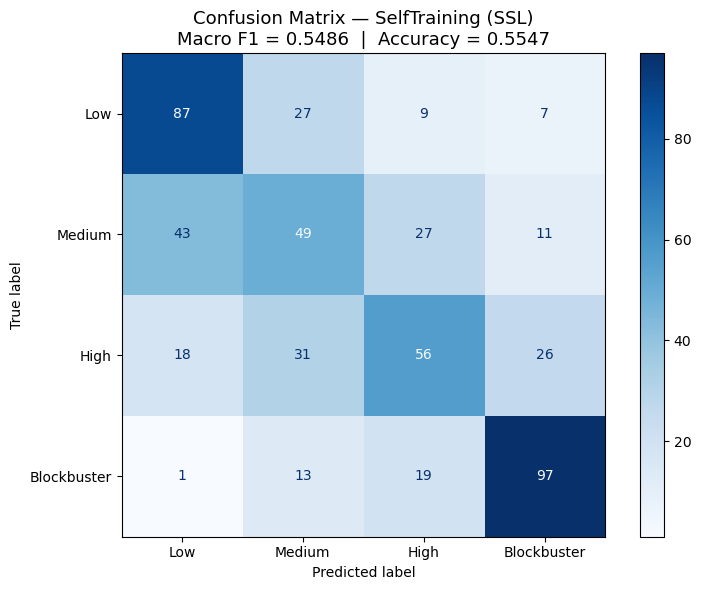

In [21]:
# ============================================================
# Step 7c — Confusion matrix plot for best model
# ============================================================
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(
    confusion_matrix=best_result["_cm"],
    display_labels=["Low", "Medium", "High", "Blockbuster"]
).plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(f"Confusion Matrix — {best_name}\nMacro F1 = {best_f1}  |  Accuracy = {best_acc}", fontsize=13)
plt.tight_layout()

cm_path = os.path.join(ARTIFACTS_DIR, "best_ssl_confusion_matrix.png")
fig.savefig(cm_path, dpi=150, bbox_inches="tight")
print(f"Saved confusion matrix plot: {cm_path}")
plt.show()

---
## Summary

| Step | Description |
|---|---|
| Validation 1 | Leakage prevention — removed post-release features |
| Validation 2 | Confirmed 4 revenue-tier classes |
| Validation 3 | Documented unlabeled proportion |
| Validation 4 | Checked dimensionality for PCA decision |
| Validation 5 | Imputed missing values if any |
| Split | 80/20 stratified on labeled data only |
| Scaling | StandardScaler fitted on labeled train |
| Baselines | GradientBoosting & RandomForest (supervised) |
| SSL Models | SelfTraining, LabelSpreading, LabelPropagation |
| Selection | Best model by macro F1 (accuracy as tiebreaker) |
| Artifacts | Comparison CSV, best model, scaler, confusion matrix |

**All evaluation was performed on a held-out labeled test set that never participated in pseudo-labeling.**